<a href="https://colab.research.google.com/github/yukaberry/detect_ai_content/blob/development/notebooks/texts/lina_text_external_features_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import string

In [2]:
from google.colab import files
uploaded = files.upload()

Saving new_dataset.csv to new_dataset.csv


In [3]:
import time
import time
from functools import wraps

def timer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function '{func.__name__}' executed in {end_time - start_time:.4f} seconds")
        return result
    return wrapper


In [4]:
df = pd.read_csv('new_dataset.csv')
df.head()


,text,generated
0,"Furthermore, the additional hours spent in sch...",1.0
1,other student have their young ones at home wh...,0.0
2,Always set a goal for yourself.\n\nEveryone in...,0.0
3,"Additionally, online classes often provide add...",1.0
4,Cars have bin around for awhile and this have ...,0.0


In [5]:
df.shape

(4670, 2)

In [6]:
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
import re
import string
import nltk
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def preprocess_text(text, remove_stopwords=True):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords, if specified
    if remove_stopwords:
        text = ' '.join(word for word in text.split() if word not in stop_words)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing to the text column
df['cleaned_text'] = df['text'].apply(lambda x: preprocess_text(x))

# Select only the necessary columns for modeling
cleaned_df = df[['cleaned_text', 'generated']]

# Display the cleaned dataset
print(cleaned_df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                        cleaned_text  generated
0  ever wondered someone feeling new technology c...        0.0
1  therefore decision seek advice expert made cau...        1.0
2  similarly relationships mistakes inevitable—bu...        1.0
3  recent years growing trend incorporating medit...        1.0
4  imagination zs invaluable tool ought used zn t...        1.0


# Functions  : SBERT, Cosine Similarity, LDA

In [8]:
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

@timer
def generate_sbert_embeddings_with_pca(df, text_column='cleaned_text', n_components=50):
    # Initialize SBERT model
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Using SBERT for embeddings
    embeddings = df[text_column].apply(lambda x: model.encode(x)).tolist()

    # Convert embeddings to DataFrame
    embedding_df = pd.DataFrame(embeddings)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embedding_df)

    # Create DataFrame for reduced embeddings
    reduced_df = pd.DataFrame(reduced_embeddings, columns=[f'pca_embedding_{i}' for i in range(n_components)])
    return pd.concat([df.reset_index(drop=True), reduced_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [9]:
import torch
import numpy as np
from sklearn.cluster import MiniBatchKMeans

@timer
def calculate_cosine_similarity(df, embeddings_column_prefix='pca_embedding_', n_components=50):
    # Extract embedding columns
    embedding_columns = [f'{embeddings_column_prefix}{i}' for i in range(n_components)]

    # Ensure embeddings are in float32
    embeddings = df[embedding_columns].astype(np.float32).values

    # K-Means clustering to identify cluster centers for AI and human texts
    kmeans = MiniBatchKMeans(n_clusters=2, random_state=42, batch_size=100).fit(embeddings)
    df['cluster_label'] = kmeans.labels_
    cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

    similarities = []
    for _, row in df.iterrows():
        # Convert row embedding to tensor and enforce float32
        text_embedding = torch.tensor(row[embedding_columns].values.astype(np.float32), dtype=torch.float32)
        cluster_center = cluster_centers[row['cluster_label']]

        # Calculate cosine similarity
        similarity = torch.nn.functional.cosine_similarity(text_embedding.unsqueeze(0), cluster_center.unsqueeze(0)).item()
        similarities.append(similarity)

    df['cosine_similarity'] = similarities
    return df.drop(columns=['cluster_label'])



In [10]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

@timer
def generate_topics(df, text_column='cleaned_text', n_topics=5):
    # Vectorize text data
    vectorizer = CountVectorizer(stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(df[text_column])

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_matrix = lda.fit_transform(doc_term_matrix)

    # Create DataFrame for topics
    topics_df = pd.DataFrame(lda_matrix, columns=[f'topic_{i}' for i in range(n_topics)])
    return pd.concat([df.reset_index(drop=True), topics_df], axis=1)

# Calling Functions

In [11]:
# SBERT embeddings with PCA

df_with_embeddings = generate_sbert_embeddings_with_pca(cleaned_df, text_column='cleaned_text')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Function 'generate_sbert_embeddings_with_pca' executed in 474.6512 seconds


In [ ]:
#df_with_embeddings.head()


In [14]:
# Call the function with the updated dataframe

df_with_cosine_similarity = calculate_cosine_similarity(df_with_embeddings)


Function 'calculate_cosine_similarity' executed in 6.1980 seconds


In [15]:
# Generate topics using LDA

df_with_lda = generate_topics(df_with_cosine_similarity)

Function 'generate_topics' executed in 25.4491 seconds


In [16]:
external_df = df_with_lda[[col for col in df_with_lda.columns if 'pca_embedding' in col] +
                       ['cosine_similarity'] +
                       [col for col in df_with_lda.columns if 'topic_' in col] +
                       ['generated']]


In [17]:
external_df.head()

,pca_embedding_0,pca_embedding_1,pca_embedding_2,pca_embedding_3,pca_embedding_4,pca_embedding_5,pca_embedding_6,pca_embedding_7,pca_embedding_8,pca_embedding_9,...,pca_embedding_47,pca_embedding_48,pca_embedding_49,cosine_similarity,topic_0,topic_1,topic_2,topic_3,topic_4,generated
0,0.221104,-0.363858,0.072701,-0.042646,0.093173,-0.167689,0.234813,-0.054135,-0.047379,0.241790,...,-0.030512,-0.018063,-0.036298,0.487257,0.000736,0.805320,0.000724,0.040880,0.152340,0.0
1,0.340046,0.169026,0.176294,0.040276,0.033332,0.030632,0.087161,0.240554,0.056096,-0.214035,...,0.013735,0.013368,-0.070489,0.138295,0.395474,0.036995,0.003360,0.501485,0.062686,1.0
2,0.192787,0.284283,0.042640,-0.063247,0.061437,0.090060,-0.060879,0.030818,0.067801,0.018514,...,0.068648,0.000808,0.051136,0.436430,0.002255,0.754987,0.002228,0.238313,0.002218,1.0
3,-0.082796,0.094322,-0.024702,-0.107373,-0.093654,-0.070279,-0.030545,-0.072316,-0.150531,0.203681,...,-0.063694,-0.014470,-0.003972,0.127981,0.000742,0.000747,0.000750,0.997003,0.000758,1.0
4,0.219795,-0.055879,0.177162,-0.028219,0.017612,-0.039700,0.318202,-0.063230,0.283117,-0.270251,...,0.007603,0.029520,0.045302,0.160095,0.002872,0.144714,0.002821,0.628142,0.221451,1.0


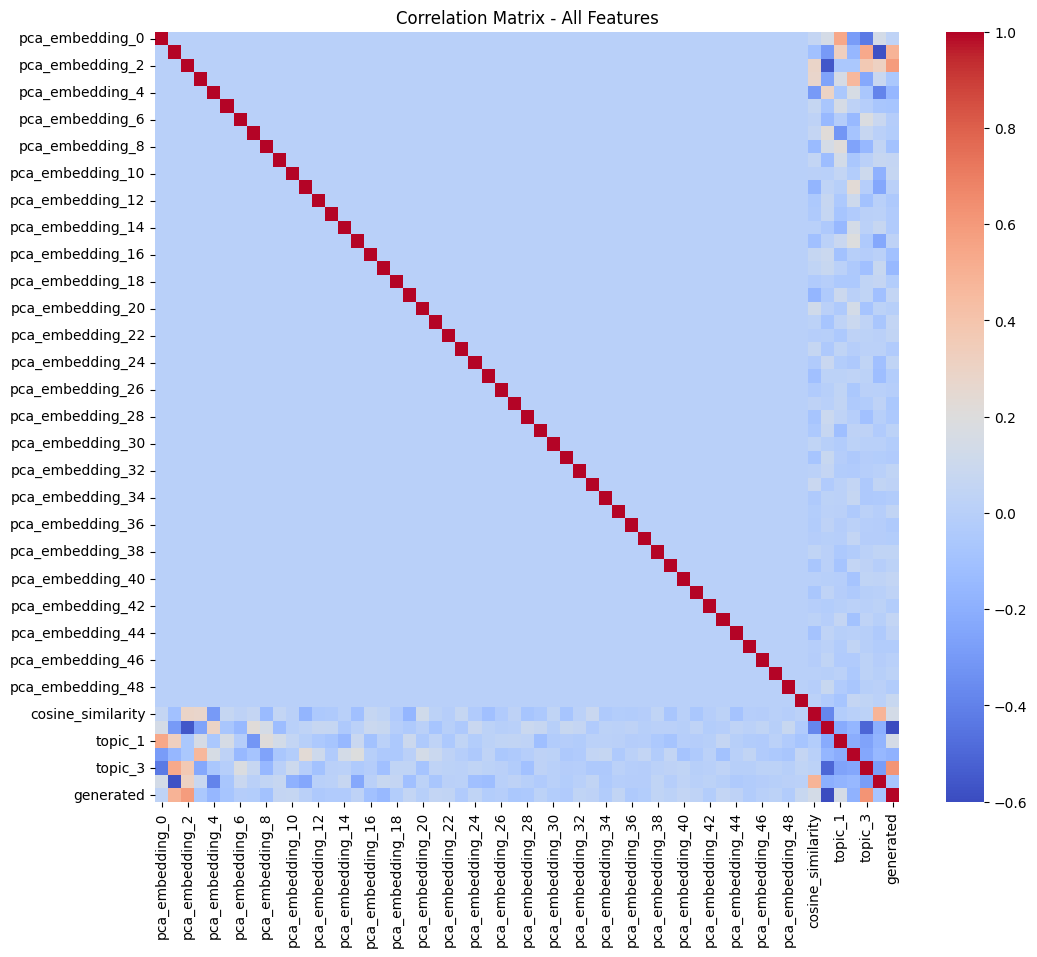


Correlation with 'generated' column:
 generated            1.000000
topic_3              0.619744
pca_embedding_2      0.588688
pca_embedding_1      0.493650
topic_1              0.143903
cosine_similarity    0.142329
pca_embedding_49     0.075397
pca_embedding_10     0.062601
pca_embedding_9      0.059921
pca_embedding_21     0.056065
pca_embedding_19     0.052087
pca_embedding_43     0.052000
pca_embedding_40     0.050652
pca_embedding_35     0.048917
pca_embedding_22     0.046090
pca_embedding_38     0.041466
pca_embedding_32     0.039016
pca_embedding_24     0.038432
pca_embedding_0      0.033740
pca_embedding_41     0.032732
pca_embedding_15     0.030271
pca_embedding_44     0.027965
pca_embedding_33     0.025518
pca_embedding_39     0.024239
pca_embedding_29     0.024038
pca_embedding_47     0.023321
pca_embedding_11     0.008847
pca_embedding_46     0.001884
pca_embedding_20    -0.000375
pca_embedding_26    -0.009935
pca_embedding_6     -0.012797
pca_embedding_18    -0.019573
p

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix for all features
plt.figure(figsize=(12, 10))
sns.heatmap(external_df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Matrix - All Features")
plt.show()

correlation_with_generated = external_df.corr()['generated'].sort_values(ascending=False)
print("\nCorrelation with 'generated' column:\n", correlation_with_generated)

# Evaluation

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import numpy as np

# Define X and y
X = external_df.drop(columns=['generated'])
y = external_df['generated']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define metrics function with AUC handling
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate AUC using predict_proba or decision_function if available
    if hasattr(model, "predict_proba"):
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    elif hasattr(model, "decision_function"):
        auc = roc_auc_score(y_test, model.decision_function(X_test))
    else:
        auc = np.nan  # If AUC cannot be calculated

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'AUC': auc}

# Define the models for evaluation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# Initialize dictionary to store trained models
trained_models = {}
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    trained_models[model_name] = model  # Store the trained model
    results[model_name] = evaluate_model(model, X_test, y_test)

# Display results in DataFrame
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print(results_df)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Training Logistic Regression...
Training SVM...
Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 1858, number of negative: 1878
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 3736, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497323 -> initscore=-0.010707
[LightGBM] [Info] Start training from score -0.010707
Training K-Nearest Neighbors...
Training Naive Bayes...
Training Gradient Boosting...
Training AdaBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model Performance Comparison:
                     Accuracy  Precision    Recall  F1 Score       AUC
Logistic Regression  0.948608   0.963387  0.929360  0.946067  0.982611
SVM                  0.965739   0.986143  0.942605  0.963883  0.989527
Random Forest        0.959315   0.979215  0.935982  0.957111  0.989805
XGBoost              0.961456   0.979310  0.940397  0.959459  0.988357
LightGBM             0.961456   0.983759  0.935982  0.959276  0.988370
K-Nearest Neighbors  0.965739   0.975169  0.953642  0.964286  0.985940
Naive Bayes          0.875803   0.887356  0.852097  0.869369  0.938029
Gradient Boosting    0.953961   0.968037  0.935982  0.951740  0.986030
AdaBoost             0.934690   0.933628  0.931567  0.932597  0.980656


# Model Tuning

In [21]:
# Select the top 2 models based on the evaluation metrics (excluding Logistic Regression)
from sklearn.model_selection import train_test_split, GridSearchCV

best_models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

# Define hyperparameter grids for tuning
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 9],
        "learning_rate": [0.01, 0.1, 0.2]
    }
}

# Hyperparameter tuning using GridSearchCV
tuned_models = {}
for model_name, model in best_models.items():
    print(f"Tuning {model_name}...")
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Store the best model
    tuned_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best AUC for {model_name}: {grid_search.best_score_}")


Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC for Random Forest: 0.9835823153881368
Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best AUC for XGBoost: 0.9857549380946009


In [24]:
import os
import pickle

In [31]:
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path in Google Drive to save the models
save_path = "/content/drive/My Drive/ProjectModels/externals"
os.makedirs(save_path, exist_ok=True)

# Save each tuned model to Google Drive
for model_name, model in tuned_models.items():
    model_path = f"{save_path}/{model_name}_tuned.pkl"
    with open(model_path, "wb") as file:
        pickle.dump(model, file)
    print(f"Saved {model_name} as {model_name}_tuned.pkl in Google Drive at {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved Random Forest as Random Forest_tuned.pkl in Google Drive at /content/drive/My Drive/ProjectModels/externals/Random Forest_tuned.pkl
Saved XGBoost as XGBoost_tuned.pkl in Google Drive at /content/drive/My Drive/ProjectModels/externals/XGBoost_tuned.pkl
